# Predicting Continuous Target Variables with Regression Analysis

### Exploring the Housing dataset

In [31]:
import numpy as np
import pandas as pd
from sklearn import datasets
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
boston = datasets.load_boston()

In [12]:
boston.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'filename'])

In [17]:
df = pd.DataFrame(boston['data'], columns=boston.feature_names)

In [18]:
df.shape

(506, 13)

In [23]:
df['MEDV'] = boston.target

In [24]:
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2,36.2


In [26]:
cols = ['LSTAT', 'INDUS', 'NOX', 'RM', 'MEDV']

/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


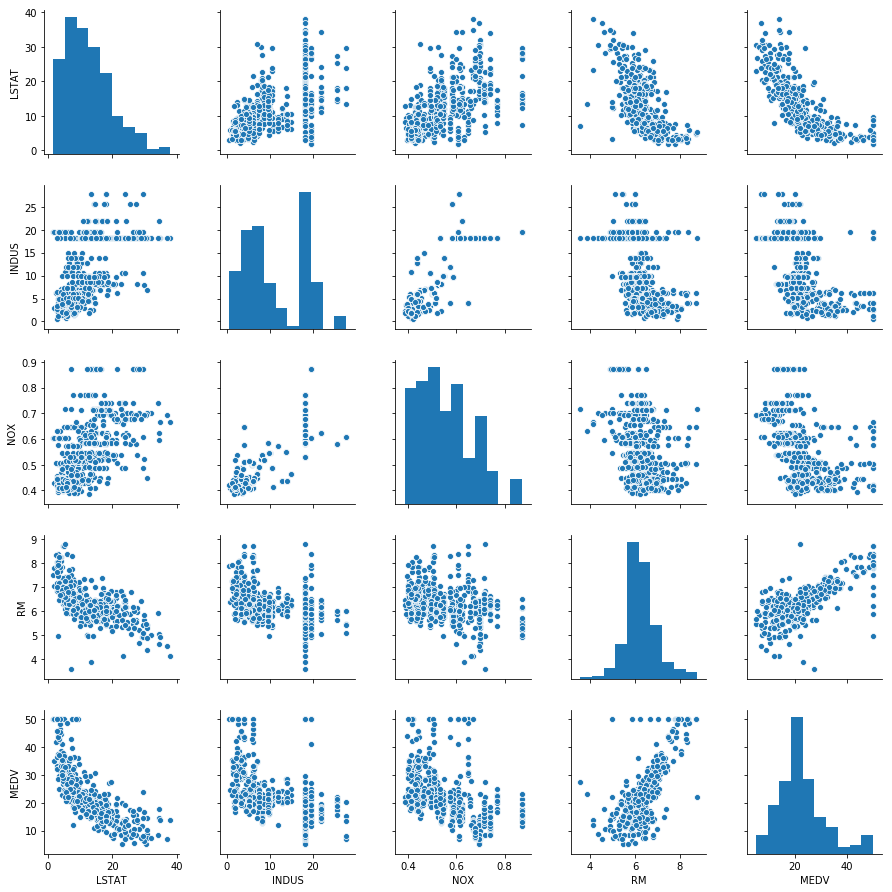

In [30]:
sns.pairplot(df[cols], size=2.5)
plt.tight_layout()
plt.show()

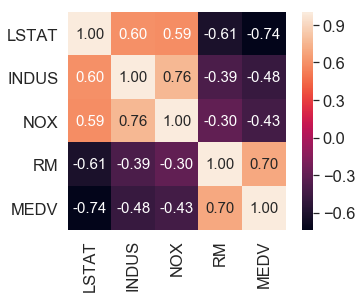

In [33]:
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.5)

hm = sns.heatmap(cm, cbar=True, annot=True, square=True,
               fmt='.2f', annot_kws={'size': 15}, 
               yticklabels=cols, xticklabels=cols)
plt.show()

### Implementing an ordinary least squares linear regression model


In [52]:
class LinearRegressionGD(object):
    
    def __init__(self, eta=0.001, epoch=20):
        
        self.eta = eta
        self.epoch = epoch
        
    def fit(self, X, y):
        
        self.weights = np.zeros(1 + X.shape[1])
        
        self.cost = []
        
        for i in range(self.epoch):
            output = self.net_input(X)
            errors = (y - output)
            self.weights[1:] += self.eta*X.T.dot(errors)
            self.weights[0] += self.eta*errors.sum()
            cost = (errors**2).sum()/2
            self.cost.append(cost)
        return self
    
    def net_input(self, X):
        return np.dot(X, self.weights[1:]) + self.weights[0]
    
    def predict(self, X):
        return self.net_input(X)

In [36]:
from sklearn.preprocessing import StandardScaler

In [37]:
X = df[['RM']].values
y = df[['MEDV']].values

In [44]:
sc_x = StandardScaler()
sc_y = StandardScaler()

X_std = sc_x.fit_transform(X)
y_std = sc_y.fit_transform(y).flatten()

In [53]:
lr = LinearRegressionGD()
lr.fit(X_std, y_std)

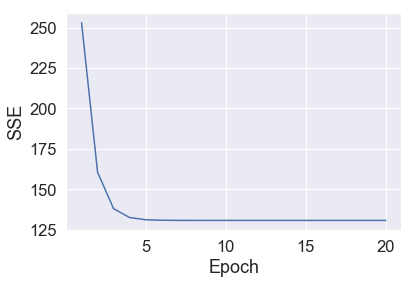

In [55]:
plt.plot(range(1, lr.epoch+1), lr.cost)
plt.ylabel('SSE')
plt.xlabel('Epoch')
plt.show()

In [56]:
def lin_report(X, y, model):
    plt.scatter(X, y, c='steelblue', 
                edgecolor='white', s=70)
    plt.plot(X, model.predict(X), color='black',
            lw=2)
    return None

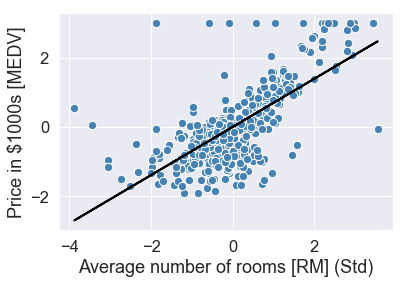

In [57]:
lin_report(X_std, y_std, lr)
plt.xlabel('Average number of rooms [RM] (Std)')
plt.ylabel('Price in $1000s [MEDV]')
plt.show()

In [60]:
print('Slope: %0.3f \nIntercept: %0.3f'%(lr.weights[1:],
                                         lr.weights[0]))

Slope: 0.695 
Intercept: -0.000


### Fitting a robust regression model using RANSAC

In [63]:
from sklearn.linear_model import RANSACRegressor
from sklearn.linear_model import LinearRegression

In [64]:
ransac = RANSACRegressor(LinearRegression(),
                        max_trials=100,
                        min_samples=50,
                        loss='absolute_loss',
                        residual_threshold=5.0,
                        random_state=0)

In [65]:
ransac.fit(X, y)

RANSACRegressor(base_estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False),
        is_data_valid=None, is_model_valid=None, loss='absolute_loss',
        max_skips=inf, max_trials=100, min_samples=50, random_state=0,
        residual_threshold=5.0, stop_n_inliers=inf, stop_probability=0.99,
        stop_score=inf)

In [74]:
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)
line_x = np.arange(3, 10, 1)
line_y_ransac = ransac.predict(line_x[:, np.newaxis])

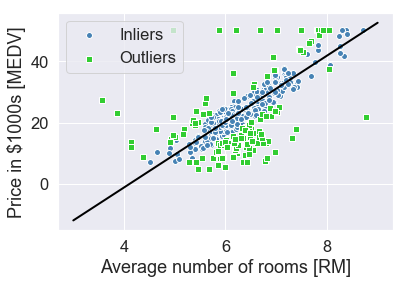

In [77]:
plt.scatter(X[inlier_mask], y[inlier_mask], 
            color='steelblue', edgecolor='white',
           marker='o', label='Inliers')
plt.scatter(X[outlier_mask], y[outlier_mask], 
            color='limegreen', edgecolor='white',
           marker='s', label='Outliers')
plt.plot(line_x, line_y_ransac, color='black', lw=2)
plt.xlabel('Average number of rooms [RM]')
plt.ylabel('Price in $1000s [MEDV]')
plt.legend(loc='upper left')
plt.show()

In [78]:
print('Slope: %0.3f \nIntercept: %0.3f'%(ransac.estimator_.coef_[0],
                                        ransac.estimator_.intercept_))

Slope: 10.735 
Intercept: -44.089


### Evaluating the performance of linear regression models

In [79]:
from sklearn.model_selection import train_test_split

In [80]:
df.shape

(506, 15)

In [81]:
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2,36.2


In [82]:
xe = df.iloc[:, :-1].values
ye = df['MEDV'].values

In [83]:
xe_train, xe_test, ye_train, ye_test = train_test_split(xe,
                                                       ye,
                                                       test_size=0.3,
                                                       random_state=0)

In [84]:
slr = LinearRegression()

In [85]:
slr.fit(xe_train, ye_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [86]:
ye_train_pred = slr.predict(xe_train)
ye_test_pred = slr.predict(xe_test)

In [88]:
error_train = ye_train_pred - ye_train
error_test = ye_test_pred-ye_test

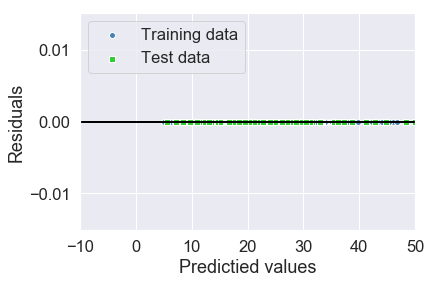

In [90]:
plt.scatter(ye_train_pred, error_train, 
            c='steelblue', marker='o', edgecolor='white',
           label='Training data')
plt.scatter(ye_test_pred, error_test, 
            c='limegreen', marker='s', edgecolor='white',
           label='Test data')
plt.xlabel('Predictied values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=50, 
           color='black', lw=2)
plt.xlim([-10, 50])
plt.show()


In [91]:
from sklearn.metrics import mean_squared_error

In [92]:
mse_train = mean_squared_error(ye_train, ye_train_pred)
mse_test = mean_squared_error(ye_test, ye_test_pred)

In [93]:
print('MSE train: %0.3f \nMSE test: %0.3f'%(mse_train, 
                                           mse_test))

MSE train: 0.000 
MSE test: 0.000


In [94]:
from sklearn.metrics import r2_score

In [95]:
r2_train = r2_score(ye_train, ye_train_pred)
r2_test = r2_score(ye_test, ye_test_pred)

In [96]:
print('R2 train: %0.3f \nR2 test: %0.3f'%(r2_train, 
                                           r2_test))

R2 train: 1.000 
R2 test: 1.000


### Using regularized methods for regression

In [97]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
ridge = Ridge(alpha=0.1)
lasso = Lasso(alpha=0.1)

In [98]:
from sklearn.linear_model import ElasticNet
elanet = ElasticNet(alpha=0.1, l1_ratio=0.5)

### Turning a linear regression model into a curve – polynomial regression

In [99]:
X = np.array([ 258.0, 270.0, 294.0, 320.0, 342.0, 
              368.0, 396.0, 446.0, 480.0, 
              586.0])[:, np.newaxis]

y = np.array([ 236.4, 234.4, 252.8, 298.6, 314.2, 
              342.2, 360.8, 368.0, 391.2, 390.8])

In [101]:
from sklearn.preprocessing import PolynomialFeatures

In [102]:
lr = LinearRegression()
pr = LinearRegression()

In [103]:
quadratic = PolynomialFeatures(degree=2)

In [104]:
x_squad = quadratic.fit_transform(X)

In [105]:
lr.fit(X, y)
x_fit = np.arange(250, 600, 10)[:, np.newaxis]
y_lin_fit = lr.predict(x_fit)

In [106]:
pr.fit(x_squad, y)
y_quad_fit = pr.predict(quadratic.fit_transform(x_fit))

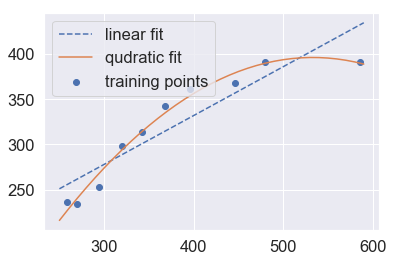

In [107]:
plt.scatter(X, y, label='training points')
plt.plot(x_fit, y_lin_fit, label='linear fit',
        linestyle='--')
plt.plot(x_fit, y_quad_fit, label='qudratic fit')
plt.legend(loc='upper left')
plt.show()

In [120]:
xl = df[['LSTAT']].values
yl = df['MEDV'].values

In [136]:
cubic = PolynomialFeatures(degree=3)

In [140]:
xl_squad = quadratic.fit_transform(xl)
xl_cubic = cubic.fit_transform(xl)

In [133]:
li_reg = LinearRegression()
sq_reg = LinearRegression()
cu_reg = LinearRegression()

In [141]:
li_reg = LinearRegression()
li_reg = li_reg.fit(xl, yl)

In [142]:
sq_reg = LinearRegression()
sq_reg = sq_reg.fit(xl_squad, yl)

In [143]:
cu_reg = LinearRegression()
cu_reg = cu_reg.fit(xl_cubic, yl)

In [144]:
li_pred = li_reg.predict(xl)
sq_pred = sq_reg.predict(xl_squad)
cu_pred = cu_reg.predict(xl_cubic)

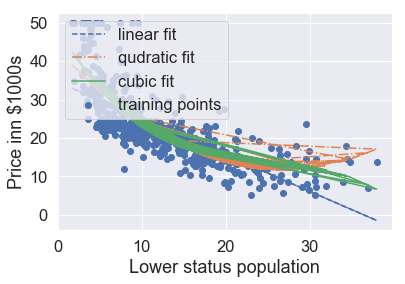

In [145]:
plt.scatter(xl, yl, label='training points')
plt.plot(xl, li_pred, label='linear fit',
        linestyle='--')
plt.plot(xl, sq_pred, label='qudratic fit', 
         linestyle='-.')
plt.plot(xl, cu_pred, label='cubic fit')
plt.xlabel('Lower status population')
plt.ylabel('Price inn $1000s')
plt.legend(loc='upper left')
plt.show()